# WeNet Evaluation On Audio Length

1. Compute Audio Length for Each Transcription
2. Compute Error
3. Generate Plots
***
### Error Metrics
1. WER
2. ROUGE

***

## Using Custom Kernel on SCC

SCC sometimes has the problem with installed library not importable [`module not found` error], this is an alternative.

Assuming you have a conda environment created, you would do the following:
1. `conda install -c anaconda ipykernel` 
2. `python -m ipykernel install --user --name=<env name>`
3. If the new kernel cannot be found, relaunch a new SCC instance

**Remember to switch to the conda env kernel**

In [1]:
ds_transcript_path = "/projectnb/ds549/projects/AImpower/datasets/updated_annotation_deid_full"

In [2]:
!pip install pandas numpy scipy tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


***

# Imports & Ingestion of Data
**We will be using the data generated from `wenet-stu-eval.ipynb`.**

In [1]:
import pandas as pd
import numpy as np
import scipy 
import os
import sys
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
net_data = pd.DataFrame(columns=["Filename", "Start_time", "End_time", "Transcript"]) 

cols = list(pd.read_csv("net_aigenerated_data_wenet_performance_stu.csv", nrows=1))
print(cols)

net_aigenerated_data_wenet = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wenet/net_aigenerated_data_wenet_performance_stu.csv', delimiter=',', usecols =[i for i in cols if "Unnamed:" not in i])

['Unnamed: 0', 'Filename', 'Start_time', 'End_time', 'WeNet', 'WER', 'Stutterance_Count', 'NA_Count', 'NA_Cleaned_Count', 'WER_Binned', 'rouge1-precision', 'rouge1-recall', 'rouge1-f1', 'rouge2-precision', 'rouge2-recall', 'rouge2-f1', 'rougel-precision', 'rougel-recall', 'rougel-f1', 'Cleaned_Transcript', 'GroundTruth_Transcript']


In [5]:
for folder in os.listdir(ds_transcript_path):
    if folder == "command_stats.xlsx" or folder == "command_stats.csv":
        continue
    for audio_sample in os.listdir(os.path.join(ds_transcript_path, f"{folder}")):
        if ("_A.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_A")])
        if ("_B.txt" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"D{folder}_B")])
        if ("P" in audio_sample):
            net_data = pd.concat([net_data, pd.read_csv(os.path.join(ds_transcript_path, f"{folder}/{audio_sample}"), sep="\t", names=["Start_time", "End_time", "Transcript"]).assign(Filename=f"P{folder}")])

In [6]:
mask_pattern = r"\<.*?\>"
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"


net_data = net_data.assign(Cleaned_Transcript=net_data['Transcript'].apply(lambda x: re.sub(annotation_pattern, "", re.sub(repetition_pattern, "", re.sub(mask_pattern, "", x)))))
net_data = net_data.assign(Stutterance_Count=net_data['Transcript'].apply(lambda x: len(re.findall(mask_pattern, x)) + len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))

In [7]:
net_data

,Filename,Start_time,End_time,Transcript,Cleaned_Transcript,Stutterance_Count
0,D0045_A,48.330,58.020,嗯，我[我/b我]现在已经工作了，我是/p一八年毕业的，然后我的专业是/p国际经济与贸易。,嗯，我现在已经工作了，我是一八年毕业的，然后我的专业是国际经济与贸易。,4
1,D0045_A,58.900,72.140,然后我现在嗯/i/p我现在的工作是/p[是]在/p[是在]<人民银行>，但是这个工作就是/p...,然后我现在嗯我现在的工作是在，但是这个工作就是可能快要就不干了。,8
2,D0045_A,74.100,81.260,嗯/i/p然后我平常的爱好是/p比较喜欢看电影，然后还喜欢打网球。,嗯然后我平常的爱好是比较喜欢看电影，然后还喜欢打网球。,3
3,D0045_A,84.930,86.320,嗯/i<overlap>结束了。,嗯结束了。,2
4,D0045_A,100.950,113.700,嗯，这个就是它[它]不是银行系统，然后它然/r后那个之所以不干，是因为就是这个，嗯/i就是现...,嗯，这个就是它不是银行系统，然后它然后那个之所以不干，是因为就是这个，嗯就是现在人民银行的县...,4
...,...,...,...,...,...,...
135,P0030,3202.732,3213.472,单曲循环歌曲最[最最]爱的为何没结果。,单曲循环歌曲最爱的为何没结果。,1
136,P0030,3216.222,3221.042,来[来]一首朴/p树的歌。,来一首朴树的歌。,2
137,P0030,3225.732,3236.142,搜[搜/r/b搜]索小灿的多/p年/p/r/b以后。,搜索小灿的多年以后。,7
138,P0030,3240.652,3253.172,播放半吨/b/r/p孙弟歌孙兄弟的歌。,播放半吨孙弟歌孙兄弟的歌。,3


In [8]:
## Assign back the cleaned transcript and original transcript
merged_data = net_aigenerated_data_wenet.merge(
    net_data[['Filename', 'Start_time', 'Cleaned_Transcript', 'Transcript']],
    on=['Filename', 'Start_time'],
    how='left'
)

net_aigenerated_data_wenet['Cleaned_Transcript'] = merged_data['Cleaned_Transcript']
net_aigenerated_data_wenet['GroundTruth_Transcript'] = merged_data['Transcript']

In [3]:
net_aigenerated_data_wenet

,Filename,Start_time,End_time,WeNet,WER,Stutterance_Count,NA_Count,NA_Cleaned_Count,WER_Binned,rouge1-precision,rouge1-recall,rouge1-f1,rouge2-precision,rouge2-recall,rouge2-f1,rougel-precision,rougel-recall,rougel-f1,Cleaned_Transcript,GroundTruth_Transcript
0,D0001_A,2081.540000,2109.650000,我说出来就比较地需要时间然后那个识别的他的不就是他等你一会你那个话还没有说完的还没有说出来的...,0.226804,1.0,100,0,0.23,0.837838,0.815789,0.826667,0.555556,0.491803,0.521739,0.803279,0.700000,0.748092,我说出来就比较的需要时间，哦，然后那个嗯识别的它的就是它等你一会儿，你那个话还没有说完，的还...,我说出来就比较的需要时间，哦，然后那个嗯/i识别的它的就是它等你一会儿，你那个话还没有说完，...
1,D0001_A,790.130000,796.580000,第四句有我我说的话,0.500000,1.0,100,0,0.50,0.800000,0.571429,0.666667,0.400000,0.333333,0.363636,0.666667,0.571429,0.615385,电视剧有，我说的话。,电视剧有，我/r说的话。
2,D0001_A,1562.083518,1586.220000,这部剧是不怎么评分是不怎么好的就因为评评论区的那那些人他们都在说拿到号做好惨的那个就那么勤奋...,0.203125,10.0,100,0,0.20,0.806452,0.806452,0.806452,0.617647,0.525000,0.567568,0.828571,0.690476,0.753247,这部剧是不怎么，评分是不怎么好的，呃就因为呃评论区的那些人，他们都在说，呃男二号就好惨的那个...,这/b部剧是不怎么，评分是不怎么好的，呃/i就因为呃/i评/r/b论区的那[那]些人，他们都...
3,D0001_A,2016.780000,2035.673559,很精准对讯飞语音还是讯飞助手来着就我记得他是叫讯飞我之前就是他,0.210526,7.0,100,0,0.21,0.888889,0.800000,0.842105,0.650000,0.464286,0.541667,0.863636,0.612903,0.716981,很精准，对，呃讯飞语音还是讯飞助手来着，就我记得它是叫讯飞，我之前就是它呃是,很[很/b]精准，对，呃/i讯飞语音还是讯飞助手来着，就[就]我记得它是叫讯/r飞，我之前就...
4,D0001_A,1682.670000,1709.110000,一个个是叫啥来的我忘了就是出现了这一个人然后呢他他就射了一把剑然后就就把那个拿二号给长杀了就...,0.250000,8.0,100,0,0.25,0.806452,0.757576,0.781250,0.512821,0.454545,0.481928,0.761905,0.653061,0.703297,一个那个是嗯叫啥来着，我忘了，就是出现了另一个人，然后呢他就射了一把剑，然后就把那个嗯男二号...,一个那个是嗯/i叫啥来着，我忘了，就是出现了另/r/b一个人，然后呢他[他]就射/p了一把剑...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37248,P0070,2586.616000,2589.346000,单曲循环歌曲这样而已,0.090909,0.0,100,0,0.09,1.000000,0.833333,0.909091,1.000000,0.800000,0.888889,1.000000,0.833333,0.909091,单曲循环歌曲这样而已。,单曲循环歌曲这样而已。
37249,P0070,2782.496000,2783.706000,杨幂的电影,0.166667,0.0,100,0,0.17,1.000000,0.750000,0.857143,1.000000,0.666667,0.800000,1.000000,0.750000,0.857143,杨幂的电影。,杨幂的电影。
37250,P0070,2995.296000,2998.116000,你好米娅今天柴油价怎么样,0.266667,0.0,100,0,0.27,0.833333,0.625000,0.714286,0.600000,0.375000,0.461538,0.833333,0.555556,0.666667,你好，米雅，今天柴油价怎么样。,你好，米雅，今天柴油价怎么样。
37251,P0070,2604.066000,2606.656000,单曲循环歌曲琉璃光之歌,0.083333,0.0,100,0,0.08,1.000000,0.833333,0.909091,1.000000,0.800000,0.888889,1.000000,0.833333,0.909091,单曲循环歌曲琉璃光之歌。,单曲循环歌曲琉璃光之歌。


**Now we have raw data of all audio transcriptions from datasets [updated_annotation_deid_full] in ```net_data``` and AI predicted transcriptions in ```net_aigenerated_data_wenet```**

In [10]:
## SAVING

net_aigenerated_data_wenet.to_csv('net_aigenerated_data_wenet_performance_stu.csv', sep=',')

***

## Compute Audio Length

In [4]:
net_aigenerated_data_wenet = net_aigenerated_data_wenet.assign(Duration=net_aigenerated_data_wenet['End_time']-net_aigenerated_data_wenet['Start_time'])

***

## Visualization of Scores

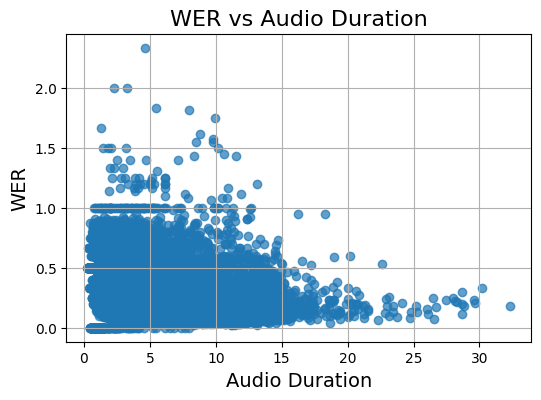

In [5]:
plt.figure(figsize=(6, 4))
plt.scatter(
    net_aigenerated_data_wenet["Duration"], 
    net_aigenerated_data_wenet["WER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("WER vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("WER", fontsize=14)
plt.grid(True)
plt.show()

In [6]:
from scipy.stats import spearmanr
rho, p = spearmanr(net_aigenerated_data_wenet.dropna()['Duration'], net_aigenerated_data_wenet.dropna()['WER'])
print(f"p-value = {p}")
print(f"rho = {rho}")

p-value = 0.0
rho = -0.3506475171407838


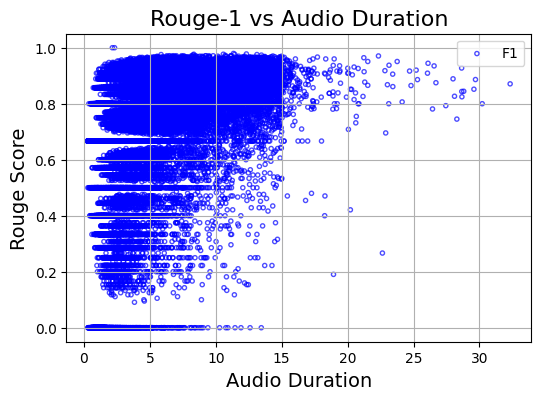

In [9]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_wenet["Duration"], 
#     net_aigenerated_data_wenet["rouge1-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_wenet["Duration"], 
#     net_aigenerated_data_wenet["rouge1-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_wenet["Duration"], 
    net_aigenerated_data_wenet["rouge1-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-1 vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

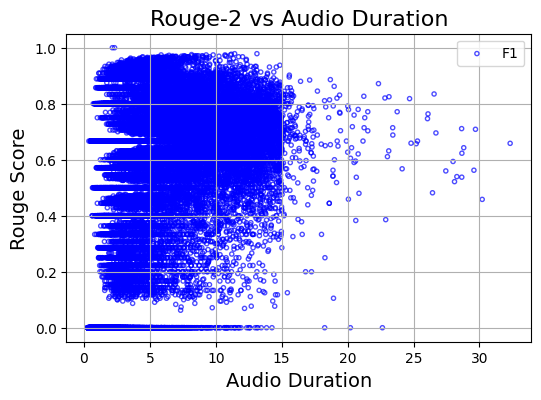

In [12]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_wenet["Duration"], 
#     net_aigenerated_data_wenet["rouge2-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_wenet["Duration"], 
#     net_aigenerated_data_wenet["rouge2-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_wenet["Duration"], 
    net_aigenerated_data_wenet["rouge2-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-2 vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

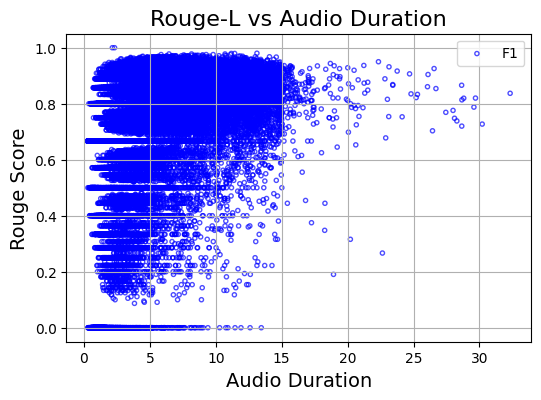

In [15]:
plt.figure(figsize=(6, 4))
# plt.scatter(
#     net_aigenerated_data_wenet["Duration"], 
#     net_aigenerated_data_wenet["rougel-precision"], 
#     facecolors="none", edgecolors='r',
#     label="Precision",
#     marker="8",
#     alpha=0.7  # Handle overlapping points
# )

# plt.scatter(
#     net_aigenerated_data_wenet["Duration"], 
#     net_aigenerated_data_wenet["rougel-recall"], 
#     facecolors="none", edgecolors='g',
#     label="Recall",
#     marker="^",
#     alpha=0.7  # Handle overlapping points
# )

plt.scatter(
    net_aigenerated_data_wenet["Duration"], 
    net_aigenerated_data_wenet["rougel-f1"], 
    facecolors="none", edgecolors='b',
    label="F1",
    marker=".",
    alpha=0.7  # Handle overlapping points
)

plt.title("Rouge-L vs Audio Duration", fontsize=16)
plt.xlabel("Audio Duration", fontsize=14)
plt.ylabel("Rouge Score", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [16]:
from scipy.stats import spearmanr

rho, p = spearmanr(net_aigenerated_data_wenet.dropna()['Duration'], net_aigenerated_data_wenet.dropna()['rouge1-f1'])
print(f"p-value [stuttering count & rouge-1 f1] = {p}")
print(f"rho [stuttering count & rouge-1 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_wenet.dropna()['Duration'], net_aigenerated_data_wenet.dropna()['rouge2-f1'])
print(f"p-value [stuttering count & rouge-2 f1] = {p}")
print(f"rho [stuttering count & rouge-2 f1] = {rho}")


rho, p = spearmanr(net_aigenerated_data_wenet.dropna()['Duration'], net_aigenerated_data_wenet.dropna()['rougel-f1'])
print(f"p-value [stuttering count & rouge-L f1] = {p}")
print(f"rho [stuttering count & rouge-L f1] = {rho}")

p-value [stuttering count & rouge-1 f1] = 0.0
rho [stuttering count & rouge-1 f1] = 0.4297193346047677
p-value [stuttering count & rouge-2 f1] = 0.0
rho [stuttering count & rouge-2 f1] = 0.3557827589847507
p-value [stuttering count & rouge-L f1] = 0.0
rho [stuttering count & rouge-L f1] = 0.3706605911312125
